In [156]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore") # ignoring annoying warnings

# from pandasql import sqldf
# pysqldf = lambda q: sqldf(q, globals())

In [157]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [158]:
%cd /content/drive/MyDrive/코드스테이츠(ai 캠프)/[S2] 머신러닝/data/walmart-recruiting-store-sales-forecasting

/content/drive/MyDrive/코드스테이츠(ai 캠프)/[S2] 머신러닝/data/walmart-recruiting-store-sales-forecasting


In [159]:
# csv 파일들을 프린트합니다
from glob import glob
for filename in glob('*.csv'):
    print(filename) # 경로 설정된 해당 폴더 안에 있는 파일 

train.csv
test.csv
sampleSubmission.csv
features.csv
stores.csv


In [160]:
# 각 파일의 shape, head를 출력하는 함수
from IPython.display import display
import pandas as pd

def preview():
    for filename in glob('*.csv'):
        df = pd.read_csv(filename, encoding='cp949') # , encoding='cp949'
        print(filename, df.shape)
        display(df.head())
        print('\n') # 폴더 안의 7개의 파일 정보 출력

In [161]:
preview()


train.csv (421570, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False




test.csv (115064, 4)


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False




sampleSubmission.csv (115064, 2)


,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0




features.csv (8190, 12)


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False




stores.csv (45, 3)


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [162]:
features = pd.read_csv('features.csv')
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

In [163]:
feat_sto = features.merge(stores, how='inner', on='Store')

In [164]:
feat_sto

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False,B,118221
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False,B,118221
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False,B,118221
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False,B,118221


In [165]:
pd.DataFrame(feat_sto.dtypes, columns=['Type'])

,Type
Store,int64
Date,object
Temperature,float64
Fuel_Price,float64
MarkDown1,float64
MarkDown2,float64
MarkDown3,float64
MarkDown4,float64
MarkDown5,float64
CPI,float64


In [166]:
train.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [167]:
pd.DataFrame({'Type_Train': train.dtypes, 'Type_Test': test.dtypes})

,Type_Train,Type_Test
Date,object,object
Dept,int64,int64
IsHoliday,bool,bool
Store,int64,int64
Weekly_Sales,float64,NaN


In [168]:
feat_sto.Date = pd.to_datetime(feat_sto.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

In [169]:
feat_sto['Week'] = feat_sto.Date.dt.week 
feat_sto['Year'] = feat_sto.Date.dt.year

In [170]:
train_detail = train.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',  'Dept','Date']).reset_index(drop=True)

In [171]:
test_detail = test.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [172]:
train_detail

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,6,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,7,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,8,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,9,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221,39,2012
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221,40,2012
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221,41,2012
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221,42,2012


In [173]:
del features, train, stores, test

In [174]:
train = train_detail.copy()
test = test_detail.copy()
# 모델링 시 필요해 카피해둠

In [175]:
null_columns = (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False).index
null_data = pd.concat([
    train_detail.isnull().sum(axis = 0),
    (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False),
    train_detail.loc[:, train_detail.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: '# null', 
                                      1: '% null', 
                                      2: 'type'}).sort_values(ascending=False, by = '% null')
null_data = null_data[null_data["# null"]!=0]
null_data

,# null,% null,type
MarkDown2,310322,0.736110,float64
MarkDown4,286603,0.679847,float64
MarkDown3,284479,0.674808,float64
MarkDown1,270889,0.642572,float64
MarkDown5,270138,0.640790,float64


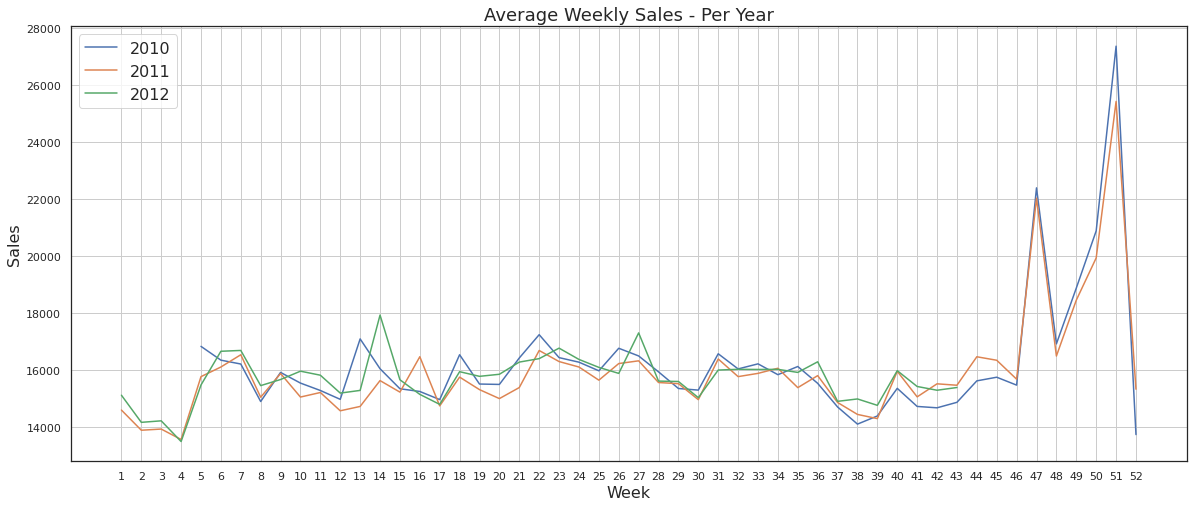

In [176]:
weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

In [177]:
train_detail.loc[(train_detail.Year==2010) & (train_detail.Week==13), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2011) & (train_detail.Week==16), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2012) & (train_detail.Week==14), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2013) & (test_detail.Week==13), 'IsHoliday'] = True

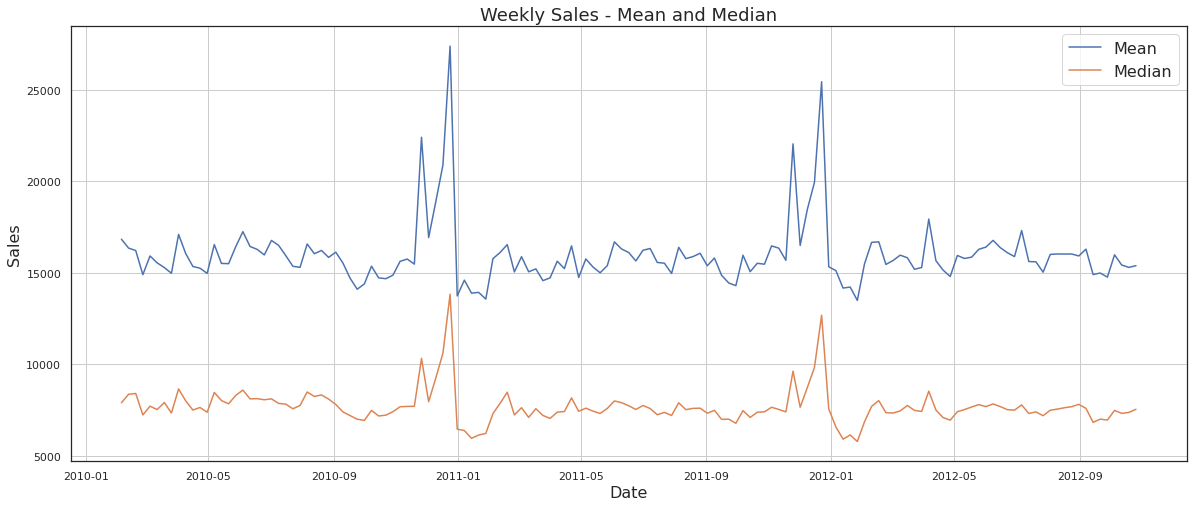

In [178]:
weekly_sales_mean = train_detail['Weekly_Sales'].groupby(train_detail['Date']).mean()
weekly_sales_median = train_detail['Weekly_Sales'].groupby(train_detail['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)
plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

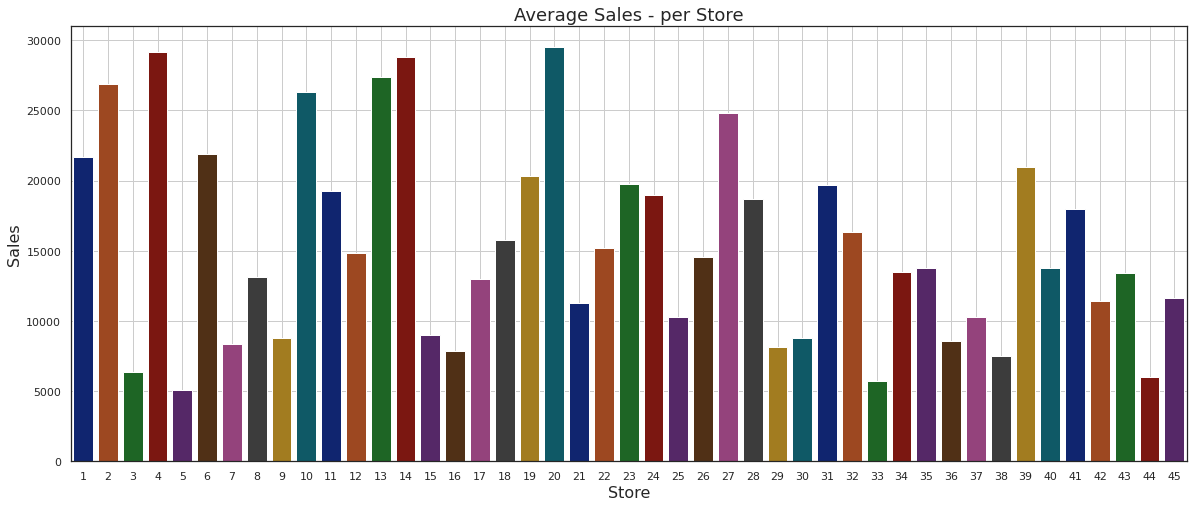

In [179]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

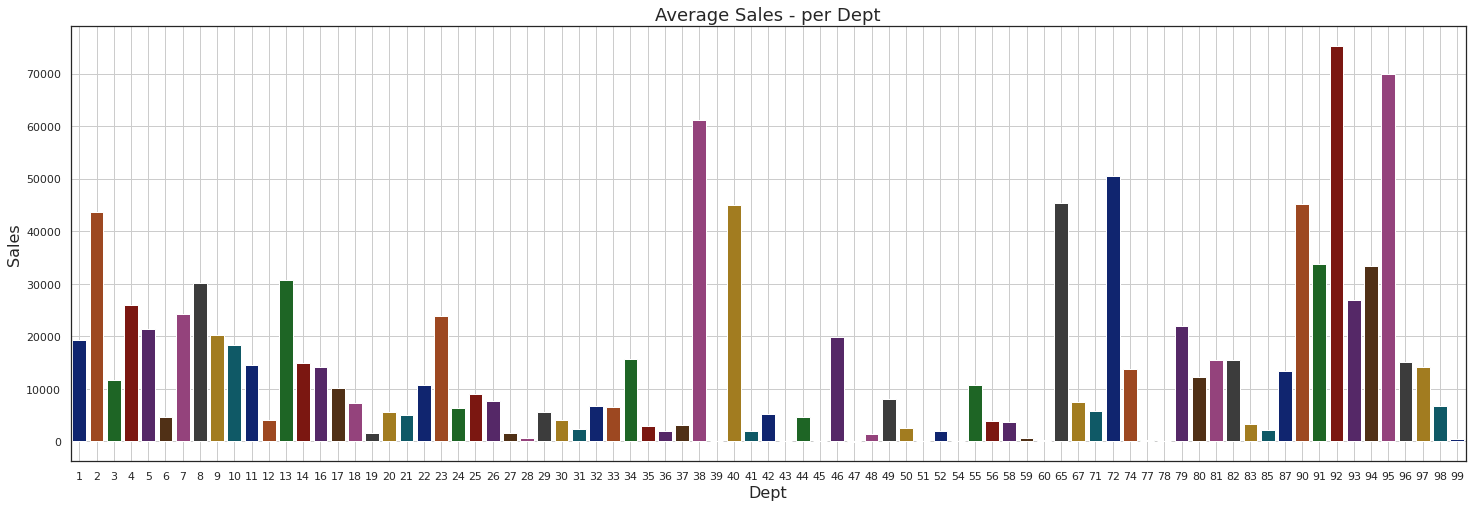

In [180]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

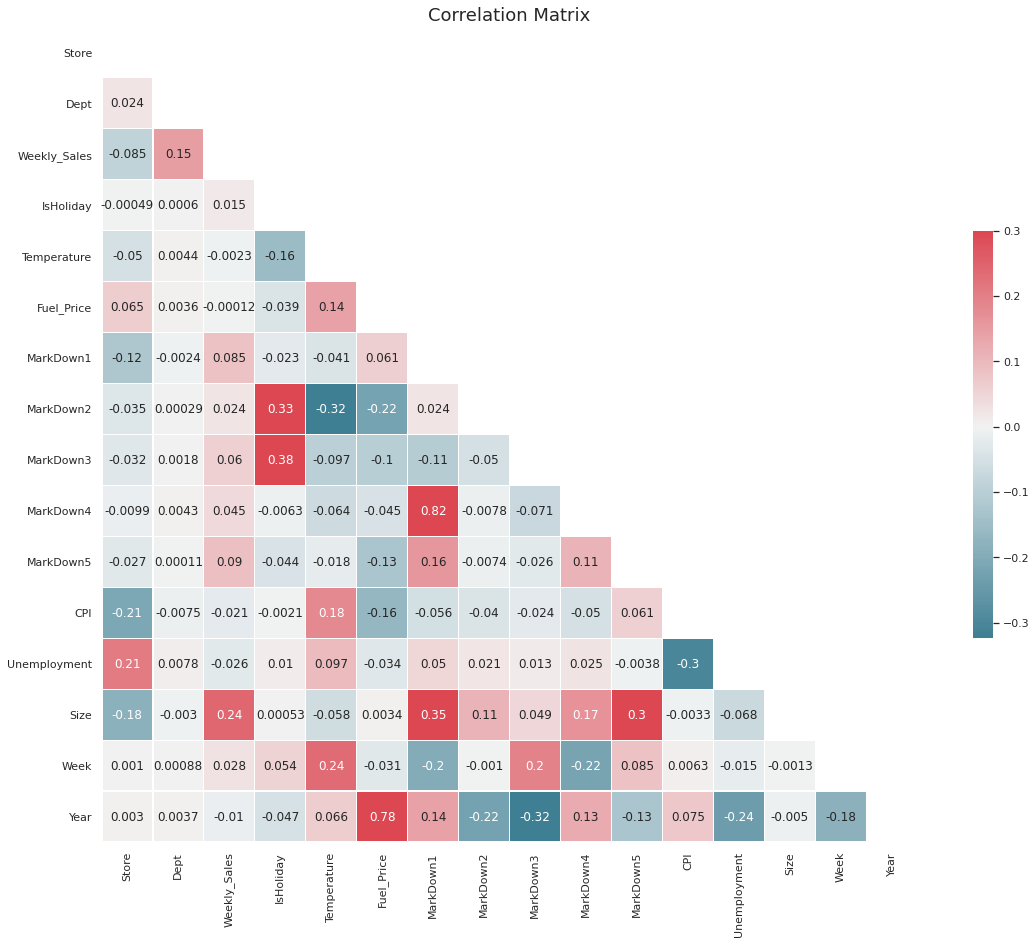

In [181]:
sns.set(style="white")

corr = train_detail.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

In [182]:
train_detail = train_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

In [183]:
def make_discrete_plot(feature):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,0]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.stripplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,1]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()

In [184]:
def make_continuous_plot(feature):
    
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(2,2)
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

    plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.15)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.15), nan_policy='omit'),2)))
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')

    plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.25)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.25), nan_policy='omit'),2)))
    
    j = sns.distplot(train_detail[feature], ax=fig.add_subplot(gs[1,1]), color = 'green')

    plt.title('Distribution\n')
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=train_detail[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(train_detail[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(train_detail[feature], nan_policy='omit'),2)))
    
    fig.show()

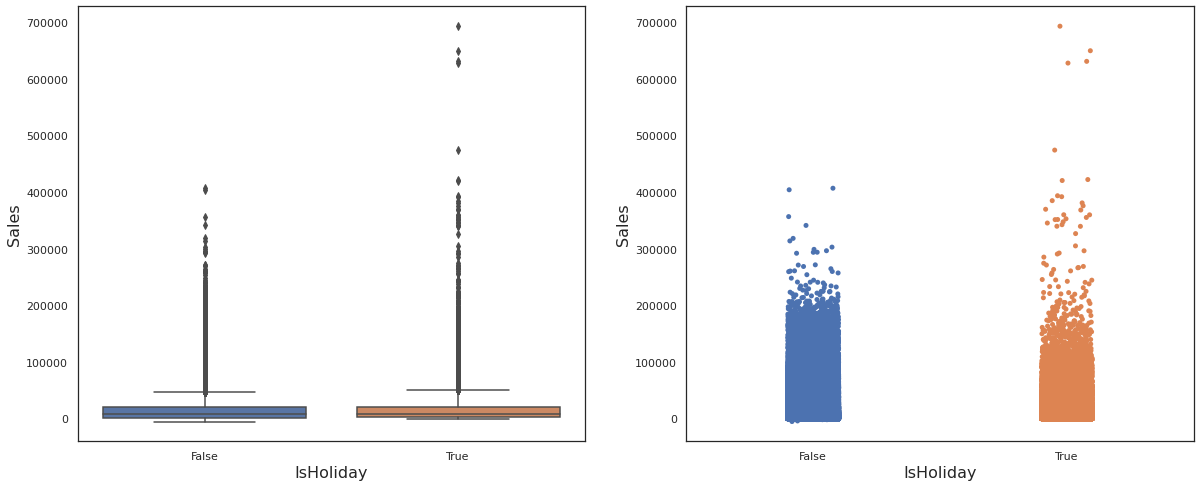

In [185]:
make_discrete_plot('IsHoliday') # 휴일 여부(세일 많이함)이 판매액에 큰 영향을 미치는 것으로 나타남

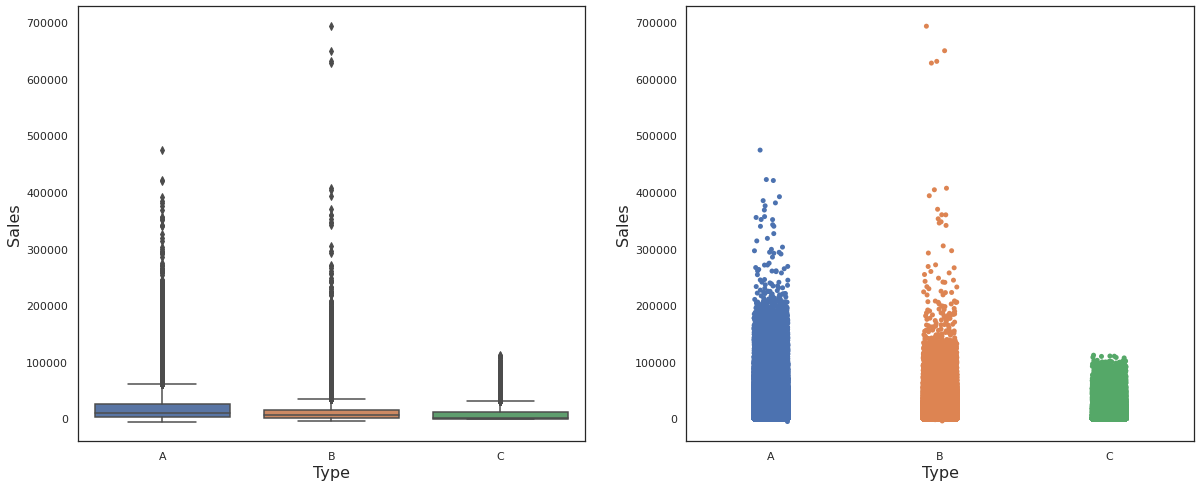

In [186]:
make_discrete_plot('Type') # 타입변수가 무엇을 의미하는 지는 알 수 없으나 알파벳순으로 판매액에 큰 영향을 미침
# 순서형 인코딩 필요

In [187]:
train_detail.Type = train_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
test_detail.Type = test_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

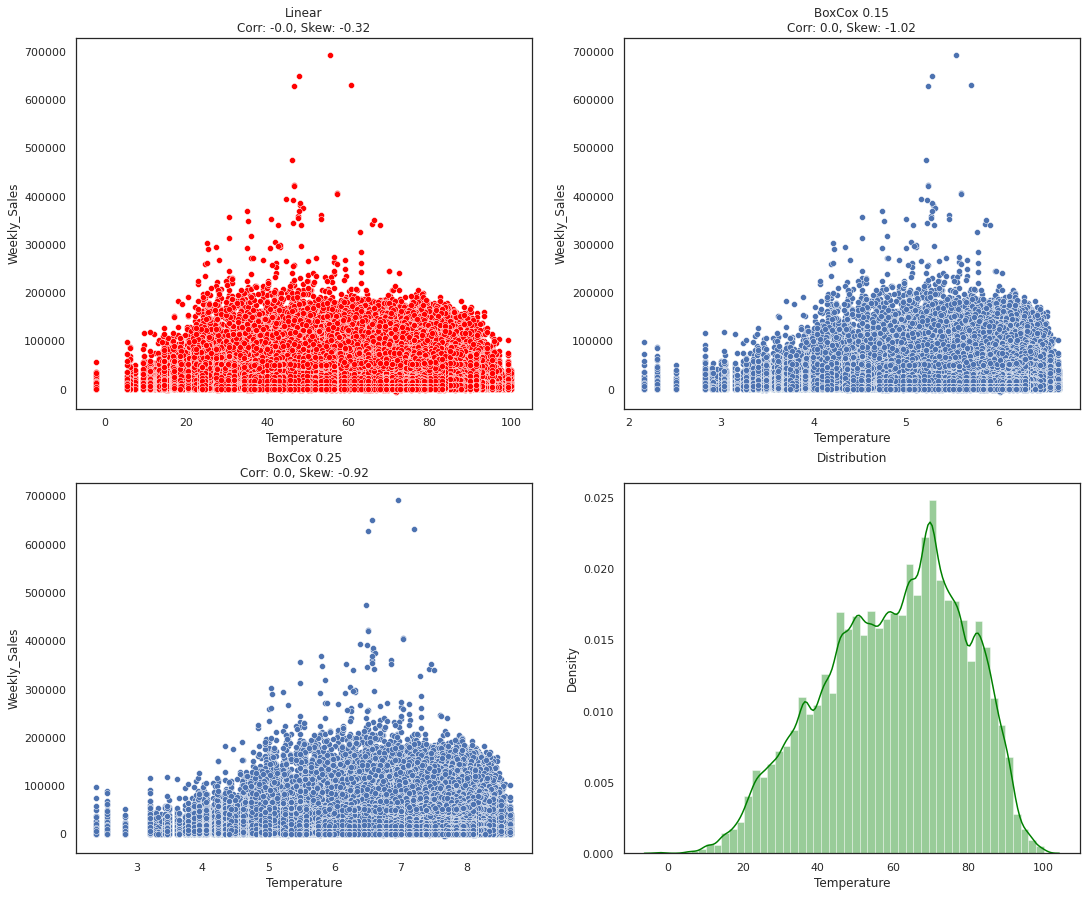

In [188]:
make_continuous_plot('Temperature') # 전처리해서 왜도를 바꾸어도 크게 상관관계를 가지지 않으므로 온도 변수 삭제

In [189]:
train_detail = train_detail.drop(columns=['Temperature'])
test_detail = test_detail.drop(columns=['Temperature'])

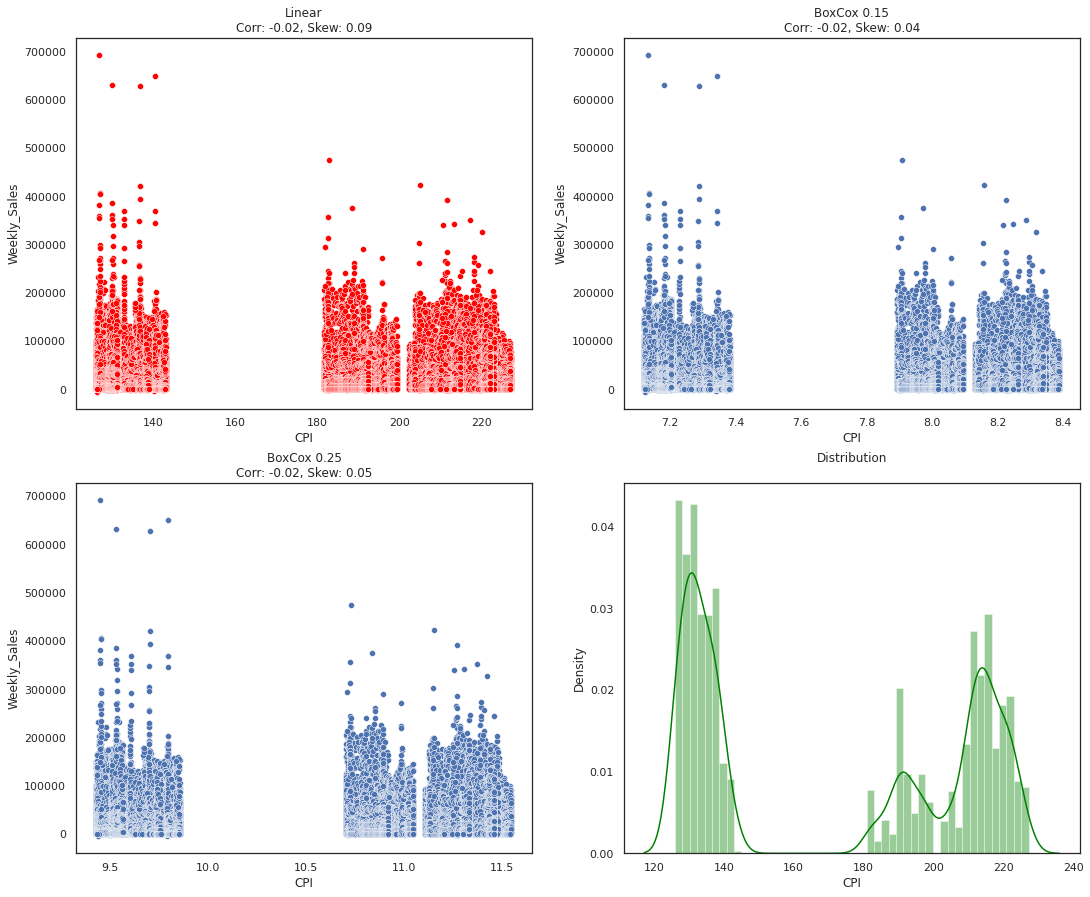

In [190]:
make_continuous_plot('CPI') # 소비자물가지수에서도 마찬가지이다. 

In [191]:
train_detail = train_detail.drop(columns=['CPI'])
test_detail = test_detail.drop(columns=['CPI'])

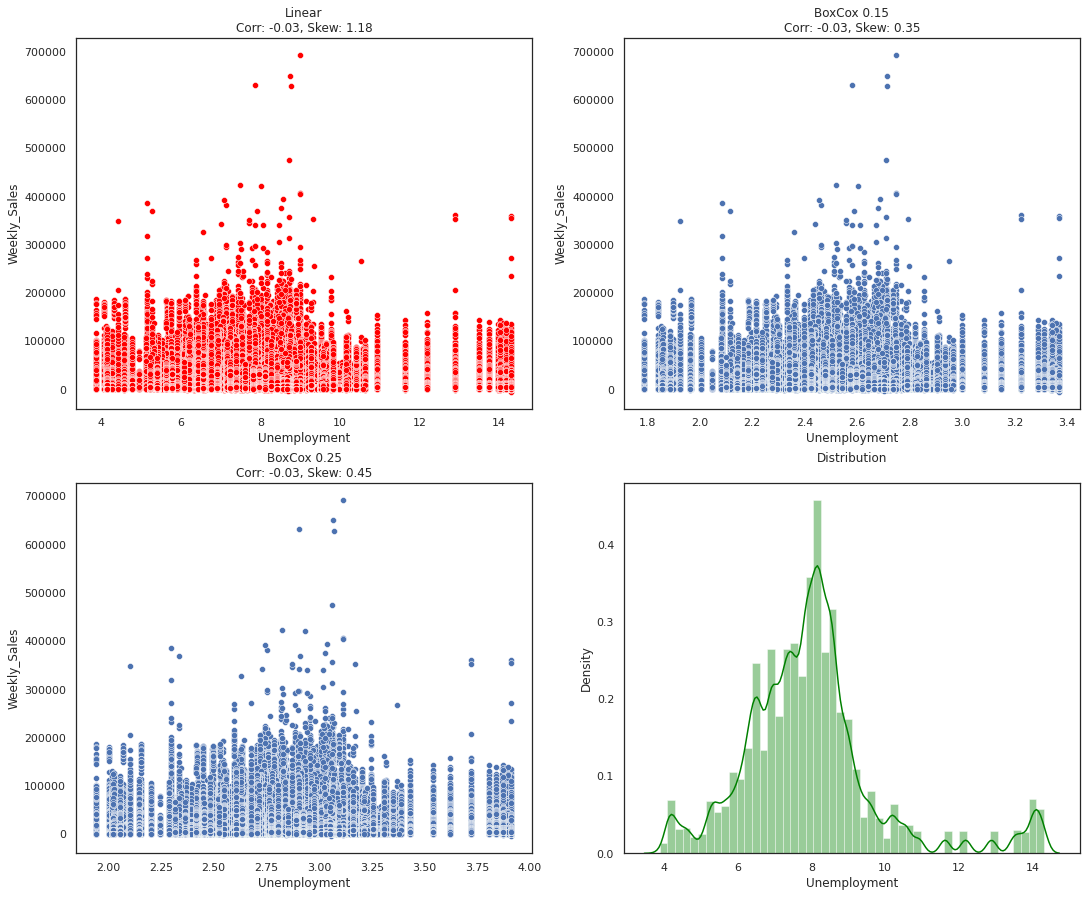

In [192]:
make_continuous_plot('Unemployment') # 실업률도 큰 영향이 없어보이므로 제거한다

In [193]:
train_detail = train_detail.drop(columns=['Unemployment'])
test_detail = test_detail.drop(columns=['Unemployment'])

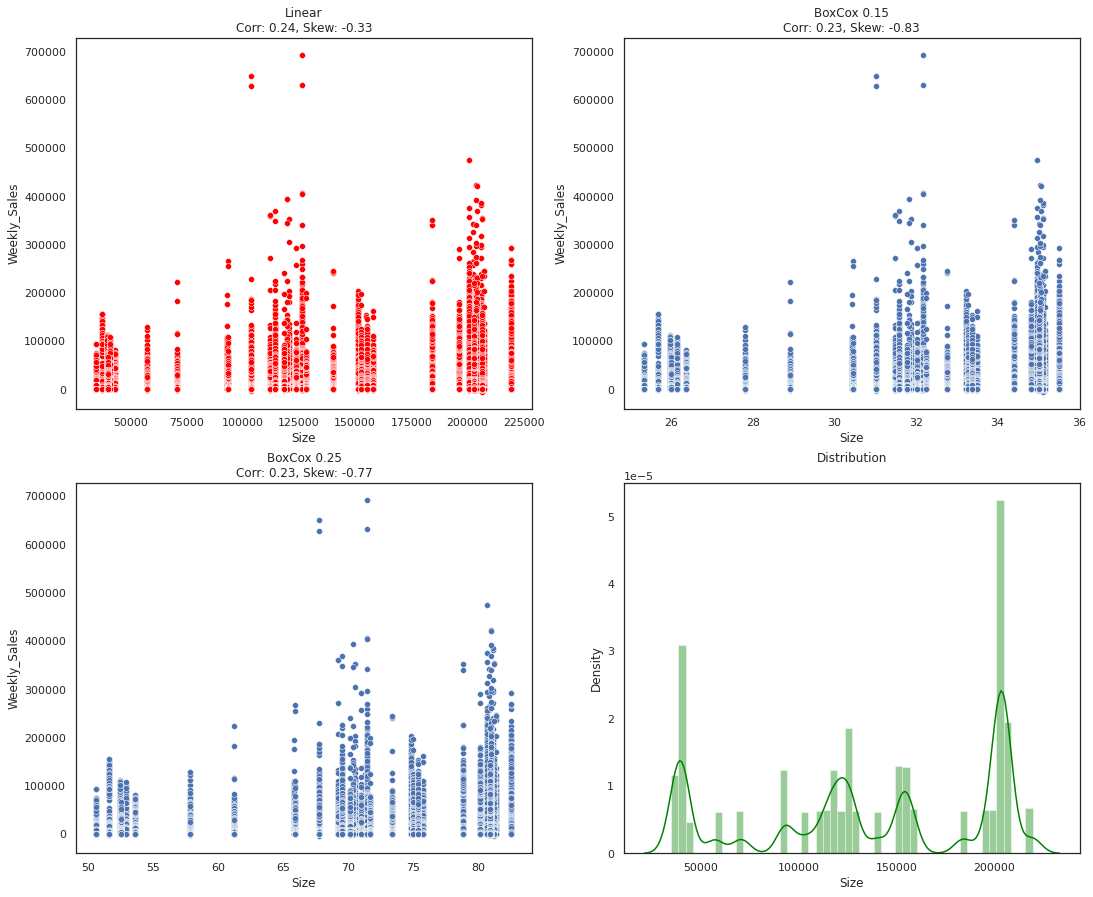

In [194]:
make_continuous_plot('Size') # 사이즈가 커질 수록 판매액과 상관관계가 있는 것으로 보이므로 유지한다.

In [195]:
 train_detail['Weekly_Sales'].mean()

15981.258123467243

# Machine Learning

In [196]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [197]:
def random_forest(n_estimators, max_depth):
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [198]:
def random_forest_II(n_estimators, max_depth, max_features):
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,5):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [199]:
def random_forest_III(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    result = []
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', min_samples_split:', split, ', min_samples_leaf:', leaf)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                           min_samples_leaf=leaf, min_samples_split=split)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Min_Samples_Leaf': leaf, 'Min_Samples_Split': split, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

## 기준모델

In [258]:
predict = train_detail['Weekly_Sales'].mean()

In [259]:
errors = predict -  train_detail['Weekly_Sales']

In [260]:
errors

0         -8943.241877
1        -30058.231877
2        -25614.291877
3         -3422.281877
4         -5846.641877
              ...     
421565    15472.888123
421566    15353.158123
421567    14920.238123
421568    15221.248123
421569    14904.458123
Name: Weekly_Sales, Length: 421570, dtype: float64

In [263]:
mean_absolute_error = errors.abs().mean()
mean_absolute_error

15161.443550936809

## Training Model

In [200]:
X_train = train_detail[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
Y_train = train_detail['Weekly_Sales']

In [ ]:
n_estimators = [56, 58, 60]
max_depth = [25, 27, 30]
# random_forest(n_estimators, max_depth)

In [ ]:
max_features = [2, 3, 4, 5, 6, 7]
# random_forest_II(n_estimators=58, max_depth=27, max_features=max_features)

In [ ]:
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3]
# random_forest_III(n_estimators=58, max_depth=27, max_features=6, 
#                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

In [ ]:
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=6, min_samples_split=3, min_samples_leaf=1)
RF.fit(X_train, Y_train)

In [ ]:
# X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
# predict = RF.predict(X_test)

# 모델해석

배운 대로 모델링

In [ ]:
test

In [ ]:
X_train = train.drop(columns=['Weekly_Sales','Date'])
X_test = test.drop(columns='Date')

y_train = train['Weekly_Sales']
# y_test = test['Weekly_Sales']


In [ ]:
pip install category_encoders

In [ ]:
# OrdinalEncoder
from category_encoders import OrdinalEncoder
Ordinal = OrdinalEncoder()
X_train = Ordinal.fit_transform(X_train)
X_test = Ordinal.transform(X_test)

In [ ]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer()
X_train_imputed = imp_mean.fit_transform(X_train)
X_test_imputed = imp_mean.transform(X_test)

In [ ]:
from sklearn.feature_selection import f_regression, SelectKBest

## selctor 정의합니다.
selector = SelectKBest(score_func=f_regression, k=7) ##-- 특성선택 방법이 진짜로 중요한 변수 7개를 똑같이 맞추는지 테스트

## 학습데이터에 fit_transform 
X_train_selected = selector.fit_transform(X_train_imputed, y_train)

## 테스트 데이터는 transform
X_test_selected = selector.transform(X_test_imputed)


X_train_selected.shape, X_test_selected.shape

In [ ]:
all_names = X_train.columns

## selector.get_support()
selected_mask = selector.get_support()

## 선택된 특성들
selected_names = all_names[selected_mask]

## 선택되지 않은 특성들
unselected_names = all_names[~selected_mask] 

print('SelectKBest 선택 변수: ', selected_names)
print('캐글 EDA로 선택된 변수:          ', ['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year'])

## -- 정말 다르다...  캐글에서 브론즈를 받은 사람의 선택한 변수인데 SelectKBest 이 방법을 믿으면 안되겠다. 

In [ ]:
df
# train_detail[target]

## 추가 모델 학습

In [202]:
# 다시 원 전처리 데이터
df = train_detail[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
features = ['Store','Dept','IsHoliday','Size','Week','Type','Year']
target = 'Weekly_Sales'

# train, val = train_test_split(df, train_size=0.80, test_size=0.02) 
                            #   stratify=train_csv[target], random_state=2)
X_train, X_val, y_train, y_val = train_test_split(df, train_detail[target], test_size=0.2, shuffle=True, random_state=34)

# X_train = train[features]
# y_train = train[target]
# X_val = val[features]
# y_val = val[target]

X_train.shape, X_val.shape

((337256, 7), (84314, 7))

In [ ]:
# OrdinalEncoder
from category_encoders import OrdinalEncoder

Ordinal = OrdinalEncoder()
Ordinal_X_train = Ordinal.fit_transform(X_train)
Ordinal_X_val = Ordinal.transform(X_val)

Ridge Regression, alpha=0.001
Test MAE: $14,587
Test R2: 0.084


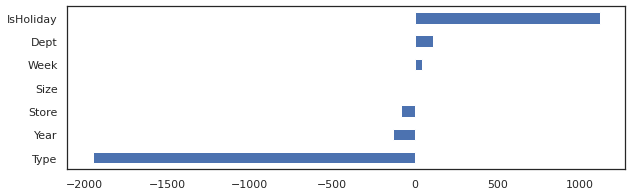

Ridge Regression, alpha=0.005
Test MAE: $14,584
Test R2: 0.084


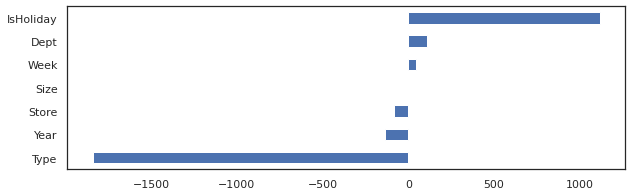

Ridge Regression, alpha=0.01
Test MAE: $14,580
Test R2: 0.084


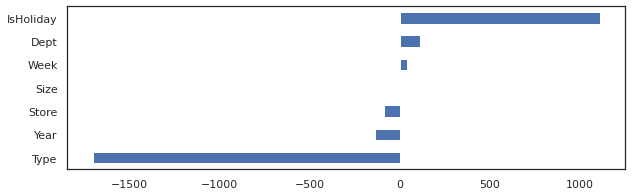

Ridge Regression, alpha=0.02
Test MAE: $14,575
Test R2: 0.084


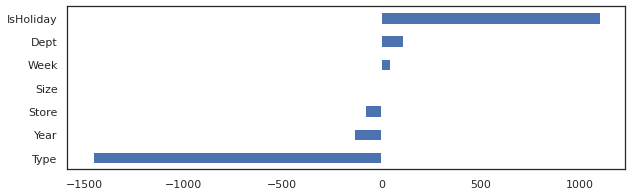

Ridge Regression, alpha=0.03
Test MAE: $14,571
Test R2: 0.084


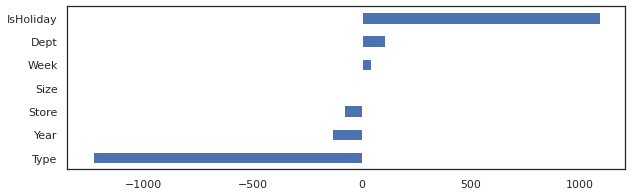

Ridge Regression, alpha=0.1
Test MAE: $14,564
Test R2: 0.083


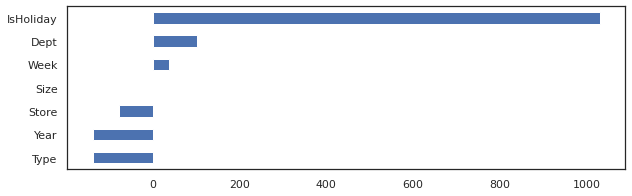

Ridge Regression, alpha=1.0
Test MAE: $14,640
Test R2: 0.066


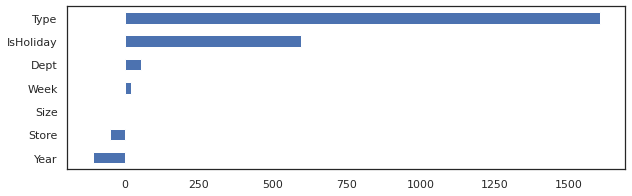

Ridge Regression, alpha=1
Test MAE: $14,640
Test R2: 0.066


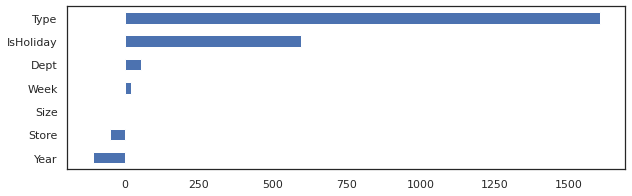

Ridge Regression, alpha=100.0
Test MAE: $15,138
Test R2: 0.002


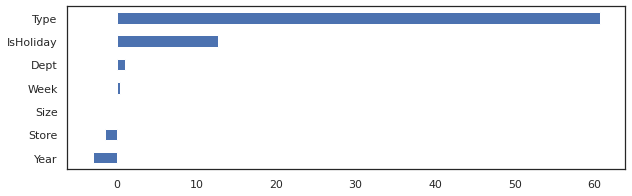

Ridge Regression, alpha=1000.0
Test MAE: $15,156
Test R2: 0.000


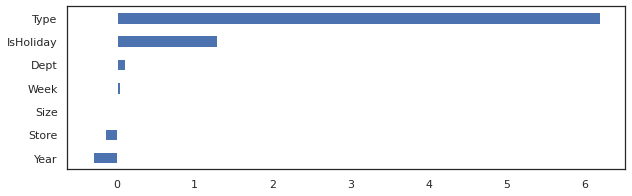

In [204]:
# 릿지 모델

from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, r2_score

for alpha in [0.001, 0.005, 0.01, 0.02, 0.03, 0.1, 1.0, 1, 100.0, 1000.0]:
        
    print(f'Ridge Regression, alpha={alpha}')

    # Ridge 모델 학습
    model = Ridge(alpha=alpha, normalize=True)  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # MAE for test
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    print(f'Test MAE: ${mae:,.0f}')
    print(f'Test R2: {r2:,.3f}')
    
    # plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(10,3))
    coefficients.sort_values().plot.barh()
    plt.show()

In [206]:
def RidgeCVRegression(degree=3, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), 
                         RidgeCV(**kwargs))

# alphas = np.linspace(0.01, 0.5, num=20)
alphas = np.arange(0.01, 0.2, 0.01)

model = RidgeCVRegression(alphas=alphas, normalize=True, cv=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f'val MAE: ${mae:,.0f}')
print(f'R2 Score: {r2:,.4f}\n')

coefs = model.named_steps["ridgecv"].coef_
print(f'Number of Features: {len(coefs)}')

print(f'alpha: {model.named_steps["ridgecv"].alpha_}')
# print(f'cv best score: {model.named_steps["ridgecv"].best_score}') # best score: R2

val MAE: $12,554
R2 Score: 0.2252

Number of Features: 120
alpha: 0.01


AttributeError: ignored

In [210]:
X_total = pd.concat([X_train, X_val])
y_total = pd.concat([y_train, y_val])

In [212]:
# 모든 데이터를 사용해 최종 모델을 만듭니다.
model = RidgeCVRegression(alphas=alphas, normalize=True, cv=5)
model.fit(X_total, y_total)

coefs = model.named_steps["ridgecv"].coef_
print(f'Number of Features: {len(coefs)}')

print(f'alpha: {model.named_steps["ridgecv"].alpha_}')
# print(f'cv best score: {model.named_steps["ridgecv"].best_score_}')

Number of Features: 120
alpha: 0.01


In [ ]:
pip install shap

In [ ]:
pip install pdpbox

In [216]:
import xgboost
import shap
shap.initjs();

In [249]:
Ridge = Ridge(alpha=0.01, normalize=True)  
Ridge.fit(X_train, y_train)


Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

In [255]:
y_pred = Ridge.predict(X_val)

# MAE for test
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f' MAE: ${mae:,.0f}')
print(f' R2: {r2:,.3f}')

 MAE: $14,580
 R2: 0.084


In [217]:
#  XGBRegressor
model = xgboost.XGBRegressor().fit(X_train, y_train)

[01:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [252]:
y_pred = model.predict(X_val)

# MAE for test
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f' MAE: ${mae:,.0f}')
print(f' R2: {r2:,.3f}')

 MAE: $6,930
 R2: 0.744


In [234]:
#  RandomForestRegressor
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=6, min_samples_split=3, min_samples_leaf=1)
RF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=27, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=58, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [253]:
y_pred = RF.predict(X_val)

# MAE for test
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'MAE: ${mae:,.0f}')
print(f'R2: {r2:,.3f}')

MAE: $1,324
R2: 0.979


In [256]:
RF.fit(X_total, y_total)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=27, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=58, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [257]:
# MAE for 최종 
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'최종 MAE: ${mae:,.0f}')
print(f'최종 R2: {r2:,.3f}')

최종 MAE: $14,580
최종 R2: 0.084


In [244]:
# ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor

clf = ExtraTreesRegressor(n_estimators=100,max_features='auto', verbose=1, n_jobs=1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=1, oob_score=False,
                    random_state=None, verbose=1, warm_start=False)

In [254]:
y_pred = clf.predict(X_val);

# MAE for test
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f' MAE: ${mae:,.0f}')
print(f' R2: {r2:,.3f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


 MAE: $1,417
 R2: 0.977


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.8s finished


In [221]:
row = X_val.iloc[[1]] 
row

,Store,Dept,IsHoliday,Size,Week,Type,Year
136243,14,81,False,200898,43,3,2010


In [226]:
y_val[1] 

46039.49

In [235]:
# 랜덤포레스트 예측
RF.predict(row)

array([40179.42438218])

In [245]:
# 모델 예측값
clf.predict(row)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array([40099.9822])

In [236]:

explainer = shap.TreeExplainer(RF)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [237]:
shap_values = explainer.shap_values(X_val.iloc[:100])

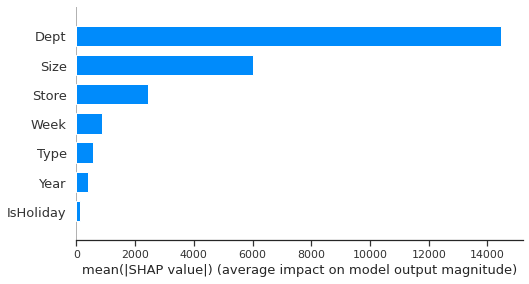

In [238]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

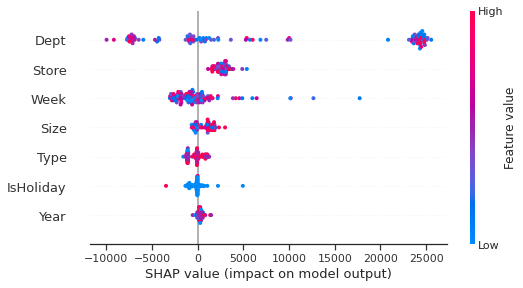

In [239]:
shap_values = explainer.shap_values(X_test.iloc[:100])
shap.summary_plot(shap_values, X_train.iloc[:100])

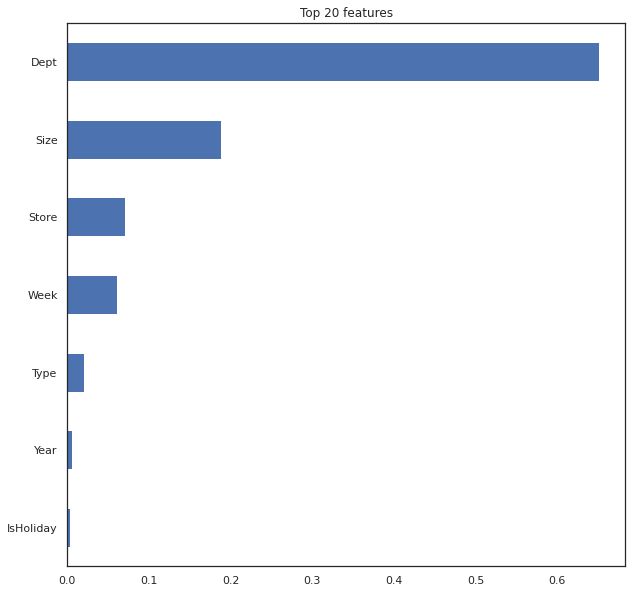

In [240]:
importances = pd.Series(RF.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


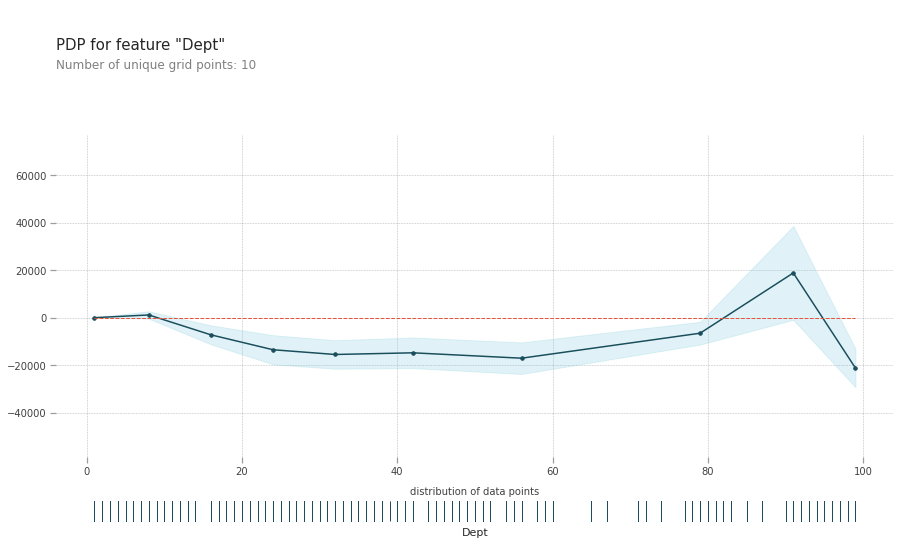

In [243]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Dept'
isolated = pdp_isolate(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature,plot_pts_dist=True); # LSTAT